# 多クラスのロジスティック回帰で手書き文字を認識

# 0. 序： なぜ、ロジスティック回帰？

線形回帰の理解からディープラーニングの理解に至る、中間段階として。

* 線形回帰 (直線フィット）
  * 最尤法による誤差関数 (と最小二乗法による誤差関数は実は同じ。）
  * 確率モデル


* ロジステック回帰 <-- 今、ここ
  * 最尤法によるパラメーター推定という点で、線形回帰と同じ
  * 確率モデルという考え方を使うと、回帰モデルは分類にも使える。
  * 複数のクラスを分類するための拡張


* ディープラーニングの基本 <-- 次のノート
  * 最尤法によるパラメーター推定という点で、線形回帰と同じ
  * 回帰モデルの入力と出力と間に、隠れ層を追加。層を深くする。（だから"深層"学習）

## 0.1 TensorFlow を動かす準備

In [1]:
import tensorflow as tf

from math import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

## 0.2 ターゲットとなるデータセット

ディープラーニング入門の定番であるMNISTデータセットを使う。
まず、ダウンロードして、mnistオブジェクトに格納しておく。

In [2]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### 0.2.1 データセットの構成

#### データセットは分割して使う
一般に、機械学習のためのデータを、３つのデータセット、学習用、検証用、テスト用に分割して使う。TensorFlowのチュートリアルではすでに分割されている。

In [3]:
print "traing data: \t\t", len( mnist.train.images),"images", len(mnist.train.labels), "labels"
print "validation data:\t", len( mnist.validation.images),"images", len(mnist.validation.labels), "labels"
print "test data: \t\t", len( mnist.test.images),"images", len(mnist.test.labels), "labels"

traing data: 		55000 images 55000 labels
validation data:	5000 images 5000 labels
test data: 		10000 images 10000 labels


学習はモデルパラメーターを最適化するために、検証は複数のモデルから最良のモデルを選ぶために、テストは未知データに対するモデルの予測精度を見積もるために、行われる。
ここでは、モデルは１種類だけを作るので、学習とテストだけを行う。
 
#### データの中身
それぞれのデータセットには画像とラベルが同数だけ含まれる。

トレーニングセットから、10個分のデータを取り出して、画像データとラベルを別々の変数に格納する。

In [4]:
images, labels = mnist.train.next_batch(10)

ラベルは、次のように、画像がどの数字に対応するかを示している。

In [5]:
print [ np.argmax(l) for l in labels[ range(10)] ]

[1, 9, 7, 8, 9, 8, 3, 4, 9, 0]


 画像をラベルと一緒に表示してみる。正しくラベルづけされている。

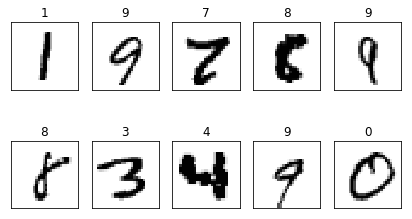

In [6]:
fig = plt.figure(figsize=(7,4))
for c, (image, label) in enumerate(zip(images, labels)):
    subplot = fig.add_subplot(2,5,c+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(label))
    subplot.imshow(image.reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation="nearest")

#### データフォーマットに注意
MNISTデータセットのなかで、画層データは784個の要素からなる一次元配列となっているので、
上のコードでは表示する前に、28x28の二次元配列に変換している。

# 1. 方法論： ロジステック回帰

## 1. 1 基本は線形回帰と同じ

線形回帰ではモデル式は次のように与えられる。
$$ f({\bf x}) = b + {\bf x \cdot w}$$  

* 独立変数 : $ {\bf x} = ( x_1 \, \ldots \, x_n)$
* モデルパラメーター
  * バイアス : $b$
  * 重み : ${\bf w}^T = ( w_1 \, \ldots \, w_n)$

このモデル式をシグモイド関数
$$ \sigma(x) = \frac{1}{ 1 + e^{- x} }  $$ 
を用いて、
$$ P( {\bf x} ) = \sigma( f({\bf x}) ) $$
のように拡張する。

この関数$P$は、独立変数$\bf x$に対応する事象についての確率であると、考える。


### 1.1.1 ここでも最尤法でモデルパラメーターを推定する

現実のデータで、独立変数$\bf x$に対応する事象が起こるかどうかを変数$t$で表すものとする。
* 事象が起きなければ、$ t = 0 $。
* 事象が起きれば、$ t = 1 $。

すると、上記の確率モデルが現実を正しく言い当てる確率は、
$$ q = \{ P( {\bf x} ) \}^t \{ 1 - P( {\bf x} ) \}^{1-t} $$
という式で計算することができる。

つまりは、この$q$で、現実のデータのなかに${\bf x}, t$というレコードが含まれるときに、その尤度（もっともらしさ）を知ることができる。

データが${\bf x_i}, t_i \ (i = 1, \ldots, N)$という$N$個のレコードから構成されるときは、その尤度は
$$ Q = \prod_{i=1}^N  \{ P( {\bf x_i} ) \}^{t_i} \{ 1 - P( {\bf x_i}) \}^{1-t_i} $$
である。

よって、この対数尤度の符号を反転させた量を、パラメーターを決めるために最小化する誤差関数として用いる。
$$ E = - \log Q = \sum_{i=1}^N [ t_i P( {\bf x_i}) + (1-t_i) \{ 1 - P( {\bf x_i}) \} ] $$

### 1.1.2 ロジステック回帰は分類に使える

誤差関数を最小化して決めたパラメーター$b, \bf w$と確率モデル$P({\bf x})$と使うと、事象$\bf x$があるクラスに属するかどうかを分類することができる。

* $P({\bf x}) < 1/2 $なら、事象$\bf x$はそのクラスに属さない。
* $P({\bf x}) \geq 1/2 $なら、事象$\bf x$はそのクラスに属する。

この分類は、$f({\bf x}) < 0$ならクラスに属さない、$f({\bf x}) \geq 0$なら属する、と識別していることと同じである。
このように$ f({\bf x})$は$\bf x$を識別するための関数ともみなせるので、機械学習の分野では、「線形識別関数」と呼ばれている。


## 1.2 多クラス分類のための拡張

まず、線形識別関数をクラスの数$K$と同じだけ用意する。
$$ f_k({\bf x}) = b_k + {\bf x \cdot w_k} \ ( k = 1, \ldots, K )$$  

モデルパラメーター$ b_k, {\bf w_k}$ は$K$組、必要になる。

そして、シグモイド関数をソフトマックス関数
$$ s_k(f_1, \ldots, f_K) = \frac{ e^{f_k} }{\sum_k e^{f_k}}  $$
で置き換える。

すると、$\bf x$がクラス$k$に属する確率を表す、確率モデル関数が得られる。
$$ P_k({\bf x}) = \frac{ \exp(f_k({\bf x}) }{\sum_k \exp(f_k({\bf x}))} $$

このモデルでは、$P_1({\bf x}), \ldots, P_K({\bf x})$のうちで$P_n$が最大となる時、$\bf x$をクラス$k$に分類する。


また、ソフトマックス関数の性質から、$P_1 + \ldots + P_K = 1$であるので、$P_k({\bf x})$が$\bf x$がクラス$k$に分類される確率であると解釈することもできる。

### 1.2.1 データとモデルを対応させるために

#### 行列、ベクトルによる表現
線形回帰のときと同様、データセットのなかの複数のレコードをまとめて表現するために、従属変数の線形識別関数をベクトル$\bf f$、独立変数を行列$X$であらわすとプログラミングしやすくなる。

$${\bf f} = b + X {\bf w}$$

* 独立変数  
  * $X$ 行列 : i番目の行$(x_{i1} \, x_{iM})$が、i番目のレコードのなかの独立変数に対応する。$M$は独立変数の数。

    * 手書き文字のデータセットMNISTは $28 \times 28 = 784$ピクセルのイメージから構成されているので、行列 X は行数は任意、列数は784であるとして、TensorFlowでは次のように定義する。

In [7]:
InputDim = 784
x = tf.placeholder(tf.float32, [None, InputDim])

#### 複数クラスを扱うために、スカラーをベクトル、ベクトルを行列に

$$ F = B + X W $$

* モデルパラメーター
   * $B$行列 : すべての行が同じ。k番目の列は、クラス$k$のためのパラメーター$b_k (k = 1,  \ldots , K)$。 
   * $W$行列 : $(j,k)$要素は、j番目の独立変数$x_j$を重み付けする、$k$番目のクラスのためのものである。$ M x K $行列。
   
ただし、TensorFlowでは、行列$B$を行ベクトル$b$として定義する。なぜなら、$ {\bf b} + XW $のように行ベクトルを行列に加算するとき、すべての行が同じ内容の行列の加算$ B +XW $ に自動的に置き換えられるように、Googleは設計しているから。（数学的記法の慣習に照らして、変な設計だと思う。しかし、フレームワークを設計するときに、厳格な数学者よりも怠惰なソフトウェア開発者にやさしくあろうとするのは良いことだと思う。それにこの設計はパフォーマンスでも有利である。）

In [8]:
ClassNum = 10
b = tf.Variable(tf.zeros([ ClassNum]))
w = tf.Variable(tf.zeros([ InputDim, ClassNum]))

* 従属変数
  * $F$行列 : (i,k)要素に、データセット中のi番目のレコードをk番目のクラスに識別するための値が入る。
  * $P$行列　: i番目の行に、$F$行列のi番目の行をソフトマックス関数で変換した値が入る。

数学的には厳密な書き方ではないが、TensorFlow は、ソフトマックス関数の組$s = \{s_1, \ldots , s_K\}$ で $F$から$P$への変換を、
$$ P = s(F) $$
と書けるようにする、関数 tensorflow.nn.softmax を提供している。 

In [9]:
f = tf.matmul(x, w) + b
p = tf.nn.softmax(f)

### 1.2.2 多クラス分類のためのモデルパラメーター決定法

#### 複数クラスを扱うために、分類のための変数t を行列に

データセットのなかのi番目のレコードにおいて、事象$\bf x_i$がクラス$k$に属することを、行列$T$のi番目の行を使って、
$$ T_{ik} = 1, \  T_{il} = 0 \, ( l \ne k) $$
のように表現する。つまり、行ベクトルのなかで、k番目の要素だけが１で、他の要素はゼロになっている。

#### 最尤法
すると、尤度は、
$$ Q = \prod_{i=1}^N \prod_{k=1}^K  \{ P_k( {\bf x_{i}} ) \}^{T_{ik}} \{ 1 - P_k( {\bf x_i}) \}^{1-T_{ik}} $$
と書き換えられるので、誤差関数は
$$ E = - \log Q = \sum_{i=1}^N \sum_{k=1}^K  [ T_{ik} P_k( {\bf x_i}) + (1-T_{ik}) \{ 1 - P_k( {\bf x_i}) \} ] $$
となる。

ここでも、Googleは誤差関数を定義するコードを簡単にするために、厳密な数学的記法とは異なる形でTensorFlowを設計している。
* 通常の行列積$ A B $は "tensorflow.matmul(A, B)" 。
* 行列A、Bの各成分をそれぞれかけ合わせる場合は "A * B" .
* 行列A のすべての成分を足し合わせるときは、 "tensorflow.reduce_sum( A)" 。

In [10]:
t = tf.placeholder( tf.float32, [ None, ClassNum])
errFunc = - tf.reduce_sum( t * tf.log(p))

#### 誤差関数の最小化は、ミニバッチによる勾配降下法で

In [11]:
trainStep = tf.train.AdamOptimizer().minimize( errFunc)

# 1.3 モデルの正解率

誤差関数は確率モデルがデータを正しく言い当てる確率から計算される量である。
確率モデルの良さを図る指標として、この他に、正解率という量もある。

正解率は、確率モデルによる分類が実際の分類と一致した比率である。

In [12]:
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# 2.  結果： 機械による学習

In [13]:
np.random.seed(20170514)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

## 2.1 ミニバッチによる勾配降下法で最適化

In [14]:
IterNum = 30000
BatchSz = 100
MonitorInterval = IterNum / 10

for i in range(1,IterNum+1):
    batchXs, batchTs = mnist.train.next_batch( BatchSz)
    sess.run(trainStep, feed_dict={x: batchXs, t: batchTs})
    if i % MonitorInterval == 0:
        errVal, accVal = sess.run([errFunc, accuracy],
            feed_dict={x:mnist.test.images, t: mnist.test.labels})
        print ('Step: %d, Err.Func.: %f, Accuracy: %f'
               % (i, errVal, accVal))

Step: 3000, Err.Func.: 2725.875000, Accuracy: 0.923700
Step: 6000, Err.Func.: 2628.608398, Accuracy: 0.926500
Step: 9000, Err.Func.: 2641.793701, Accuracy: 0.926700
Step: 12000, Err.Func.: 2621.302246, Accuracy: 0.928200
Step: 15000, Err.Func.: 2642.274902, Accuracy: 0.927600
Step: 18000, Err.Func.: 2694.154053, Accuracy: 0.926900
Step: 21000, Err.Func.: 2669.924805, Accuracy: 0.928100
Step: 24000, Err.Func.: 2715.356445, Accuracy: 0.928000
Step: 27000, Err.Func.: 2690.238770, Accuracy: 0.928700
Step: 30000, Err.Func.: 2747.899414, Accuracy: 0.926700


学習データにおける正解率が93% で頭打ちになったので、モデルパラメータ最適化はここまでとする。

## 2.2 モデルのテスト

学習データで最適化されたモデルで、テストデータを分類してみる。

分類が妥当かどうかを見るべく、「０」〜「９」の数字に対して、正解と不正解の例を３個ずつ表示してみる。

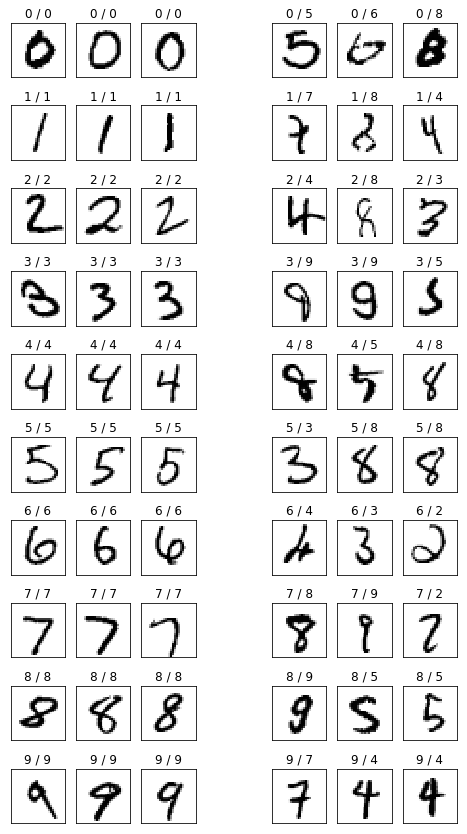

In [20]:
images, labels = mnist.test.images, mnist.test.labels
p_val = sess.run(p, feed_dict={x:images, t: labels}) 

fig = plt.figure(figsize=(8,15))
for i in range(10):
    c = 1
    for (image, label, pred) in zip(images, labels, p_val):
        prediction, actual = np.argmax(pred), np.argmax(label)
        if prediction != i:
            continue
        if (c < 4 and i == actual) or (c >= 4 and i != actual):
            if c != 4 :
                subplot = fig.add_subplot(10,7,i*7+c)
                subplot.set_xticks([])
                subplot.set_yticks([])
                subplot.set_title('%d / %d' % (prediction, actual))
                subplot.imshow(image.reshape((28,28)), vmin=0, vmax=1,
                           cmap=plt.cm.gray_r, interpolation="nearest")
            c += 1
            if c > 7:
                break

### 2.2.1 ロジステック回帰（ディープラーニング以外の機械学習）の弱点

ロジステック回帰によるモデルが正解できなった画像のなかには、人間であれば簡単に正解できるものが多く含まれている。

これはロジステック回帰による分類の限界を示していると思われる。そもそも、ロジステック回帰では、画像を784次元のベクトル空間における点$\bf x$に対応するとみなして、ベクトル空間を線形識別関数$f_k({\bf x})$で10個に区切り、点$\bf x$がこの10個の領域のどこに入っているかで画像を分類している。

* 1) 今回、機械ができなかった分類を人間が行うことができるのは、文字の画像が回転したり並進移動しても、人間はその画像を同じ文字だとみなすことができるからである。しかし、回転したり並進した画像を同じ文字であると機械に分類させるには、ベクトル空間を線形識別関数$f_k({\bf x})$で切り出されるような単純な形状ではなく、かなり複雑な形状に区切る必要があると思われる。
  * しかし、線形識別関数$f_k({\bf x})$によるベクトル空間の分割では、ある数字に対応する${\bf x}$と領域として単純な凸型の領域しか表現できない。これは二層回路のパーセプトロンにおいて、線形識別関数の境界面 $f_k({\bf x}) = f_l({\bf x})$で囲まれた凸型の領域しか表現できないのと同じである。

* 2) また、ロジスティック回帰による分類では、パラメーターで大きく重みづけされているピクセルが黒いか白いかで、画像の分類は左右される。しかし、人間が画像を分類するときには、そのように局所的な情報から判断しているのではなく、画像の全体から文字の判別に重要な特徴、ストロークの相対位置、関係などを取り出して、判断している。

（などど、長々と調子にのって書いてしまいました。しかし、上記のように書けるのは、実は、どのようにロジステック回帰のモデルを改良して正解率が上がったかを、入門書を読んで知っているからです。すみません。）


#### ディープラーニングへ

そこで、次のノートでは上の弱点1),2)を克服するために、以下の改良を加えます。

* 弱点1)を克服するために、パーセプトロン回路で層を増やすように、入力変数とソフトマックス関数の間に、新たな層を加える。つまりは、層をディープにする。
* 弱点2)を克服するために、さらに層を増やす。そして、増やした層の間で、フィルター処理とプーリング処理によって画像の特徴が抽出されるようにする。

# まとめ

* 多クラス分類のために拡張されたロジステック回帰（ソフトマックス関数による回帰）で、手書き文字を分類した。
  * 学習データでの正解率は93%。
* さらに正解率を上げるべく、つぎは、ディープラーニング！